# Part 1 - Data Acquisition

In [268]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import time
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model

In [269]:
ranks = []
titleLengths = []
ages = []
numPoints = []
numComments = []

def scrapeHacker():
    
    for x in range(1,6):
        url = f"https://news.ycombinator.com/news?p={x}"
        time.sleep(1)
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        
        articleRankTitle = soup.find_all("tr", class_="athing")
        articleAgePtsComms = soup.find_all("td", class_="subtext")
        
        for data in articleRankTitle:
            rank = data.find("span", class_='rank').text.strip(".")
            ranks.append(int(rank))
            
            titleLength = len(data.find("span", class_='titleline').text.strip())
            titleLengths.append(int(titleLength))
            
        for data in articleAgePtsComms:
            age = data.find("span", class_='age').text.strip(' ago')
            pts = data.find("span", class_='score')
            comments = data.find_all("a", href=lambda href: href and "item?id" in href)[-1]

            # get age
            if "minute" in age:
                age = age.replace("minutes", "").replace("minute", "")
                ages.append(int(age)/60)
            elif "day" in age:
                age = age.replace("days", "").replace("day", "")
                ages.append(int(age)*24)
            else:
                age = age.replace("hours", "").replace("hour", "")
                ages.append(int(age))
        
            # get points
            if pts is None:
                numPoints.append(0)
            else:
                pts = pts.text.replace("points", "").replace("point", "")
                numPoints.append(int(pts))
            
            # get comments
            if "comment" not in comments.text:
                numComments.append(0)
            else:
                comments = comments.text.replace("comments", "").replace("comment", "")
                numComments.append(int(comments))
scrapeHacker()            

In [270]:
# create data frame from data
dataframe = pd.DataFrame({'Rank': ranks, "TitleLength": titleLengths, "AgeInHours": ages, "Points": numPoints, "NumberOfComments": numComments})
# save data frame to a file
dataframe.to_csv("hackerNews.csv", index=False)

# Part 2 - Regression

In [271]:
myDF = pd.read_csv("hackerNews.csv")
myDF

,Rank,TitleLength,AgeInHours,Points,NumberOfComments
0,1,37,0.55,80,36
1,2,38,5.00,475,208
2,3,65,5.00,454,198
3,4,49,4.00,244,101
4,5,85,1.00,42,29
...,...,...,...,...,...
145,146,48,6.00,48,51
146,147,89,24.00,201,119
147,148,34,6.00,8,4
148,149,71,21.00,76,25


                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     33.14
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           1.32e-12
Time:                        19:07:01   Log-Likelihood:                -750.15
No. Observations:                 150   AIC:                             1506.
Df Residuals:                     147   BIC:                             1515.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.8626      4.750     10.707      0.0

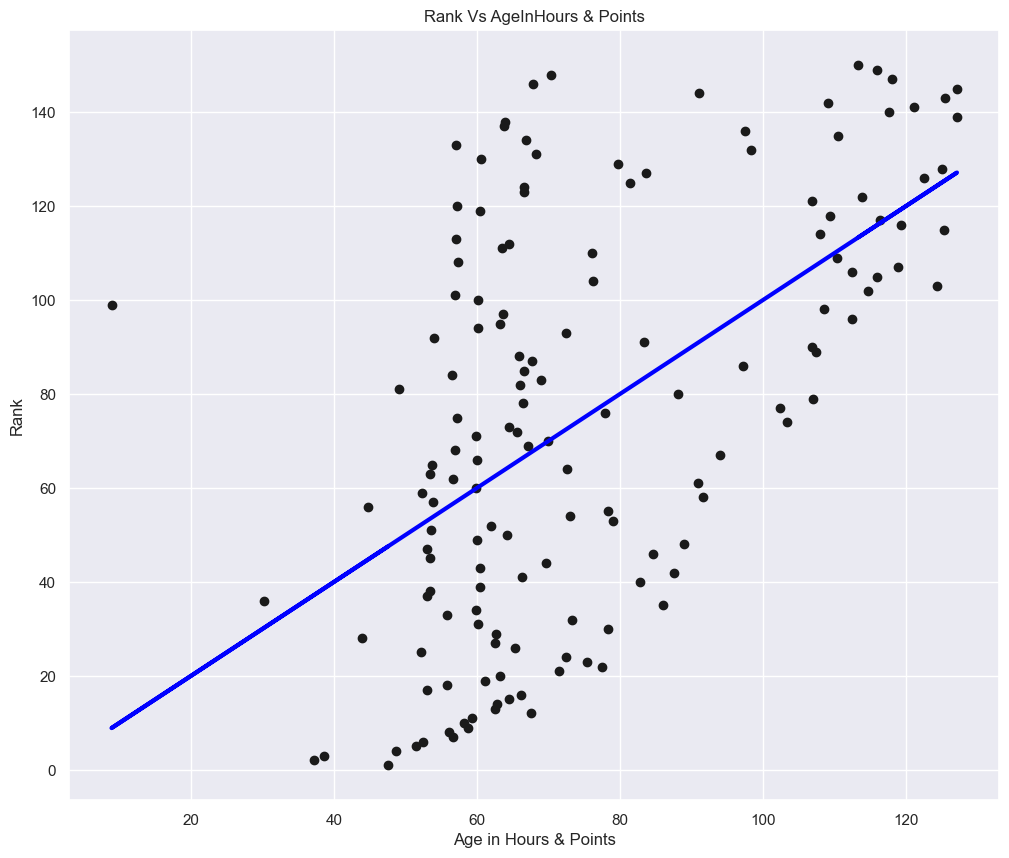

In [272]:
# Model 1: Rank Vs AgeInHours & Points

agePointResult = smf.ols('Rank ~ AgeInHours + Points', data=myDF).fit()
print(agePointResult.summary()) 
par = agePointResult.params
print(par)

# combine age and points
myDF['AgeAndPoints'] = par['Intercept'] + par['AgeInHours'] * myDF['AgeInHours'] + par['Points'] * myDF['Points']
plt.scatter( x=myDF['AgeAndPoints'],y=myDF['Rank'], c='k')
plt.plot( myDF['AgeAndPoints'], agePointResult.predict(), color='blue', linewidth=3 )

_ = plt.xlabel( 'Age in Hours & Points' )
_ = plt.ylabel( 'Rank' )
_ = plt.title("Rank Vs AgeInHours & Points")

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     29.01
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           2.40e-11
Time:                        19:07:02   Log-Likelihood:                -753.11
No. Observations:                 150   AIC:                             1512.
Df Residuals:                     147   BIC:                             1521.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           51.0280      4.852  

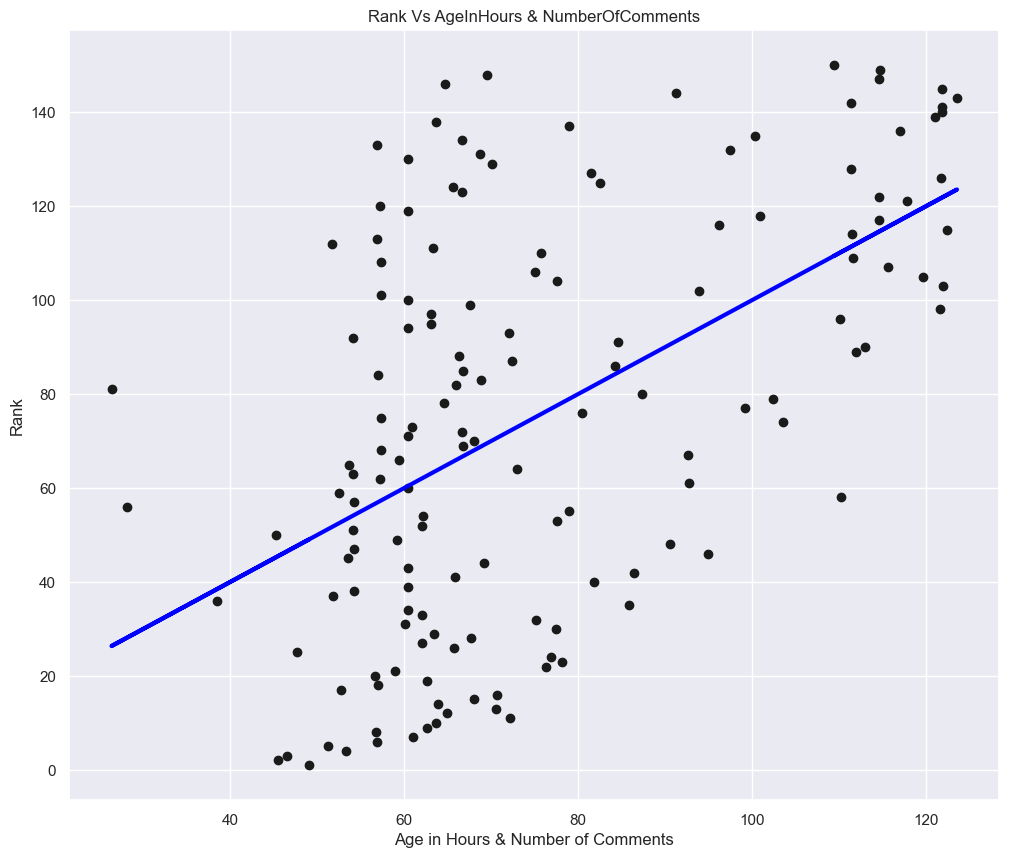

In [273]:
# Model 2: Rank Vs AgeInHours & NumberOfComments

ageCommentResult = smf.ols('Rank ~ AgeInHours + NumberOfComments', data=myDF).fit()
print(ageCommentResult.summary()) 
par = ageCommentResult.params
print(par)

# combine age and points
myDF['AgeAndComments'] = par['Intercept'] + par['AgeInHours'] * myDF['AgeInHours'] + par['NumberOfComments'] * myDF['NumberOfComments']
plt.scatter( x=myDF['AgeAndComments'],y=myDF['Rank'], c='k')
plt.plot( myDF['AgeAndComments'], ageCommentResult.predict(), color='blue', linewidth=3 )

_ = plt.xlabel( 'Age in Hours & Number of Comments' )
_ = plt.ylabel( 'Rank' )
_ = plt.title("Rank Vs AgeInHours & NumberOfComments")

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     21.83
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           4.99e-09
Time:                        19:07:02   Log-Likelihood:                -758.56
No. Observations:                 150   AIC:                             1523.
Df Residuals:                     147   BIC:                             1532.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      43.1395     11.269      3.828      

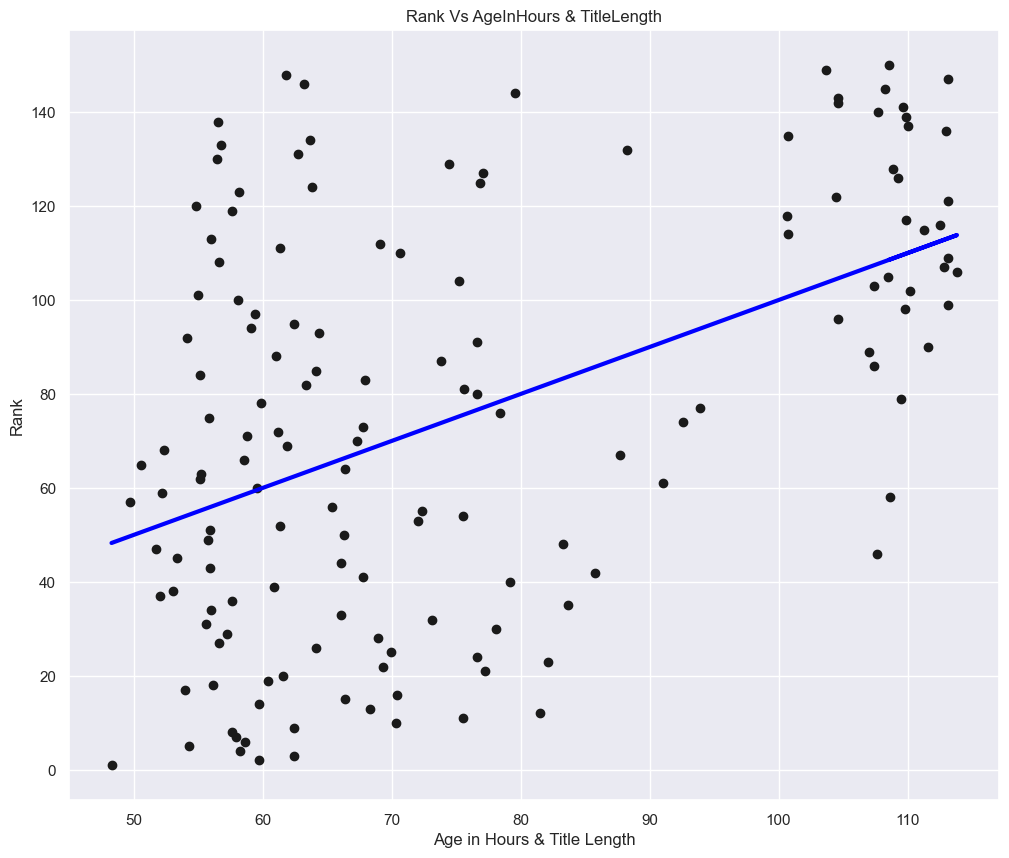

In [274]:
# Model 3: Rank Vs AgeInHours & TitleLength

ageTitleResult = smf.ols('Rank ~ AgeInHours + TitleLength', data=myDF).fit()
print(ageTitleResult.summary()) 
par = ageTitleResult.params
print(par)

# combine age and points
myDF['AgeAndTitle'] = par['Intercept'] + par['AgeInHours'] * myDF['AgeInHours'] + par['TitleLength'] * myDF['TitleLength']
plt.scatter( x=myDF['AgeAndTitle'],y=myDF['Rank'], c='k')
plt.plot( myDF['AgeAndTitle'], ageTitleResult.predict(), color='blue', linewidth=3 )

_ = plt.xlabel( 'Age in Hours & Title Length' )
_ = plt.ylabel( 'Rank' )
_ = plt.title("Rank Vs AgeInHours & TitleLength")


### Include at least 3 different regressions. Compare/contrast them. Which is the most useful? What are the R^2 scores, p-values for coefficients, and values of the coefficients - and what do these tell us? 

| Method | R-Squared | P-Value(s) | Coefficient(s) |
| --- | --- | --- | --- |
| Rank ~ AgeInHours + Points | 0.340 | 0.000, 0.000 | 3.4306, -0.0580 | 
| Rank ~ AgeInHours + NumberOfComments | 0.311 | 0.000, 0.004 | 3.2256, -0.0824 |
| Rank ~ AgeInHours + TitleLength | 0.270 | 0.000. 0.996 | 2.6994, -0.006 |

From the looks of it, I would argue that the regression betwen rank ~ ageInHours + points is the most useful. This is beacuse this method has the highest r-sqaured value at 0.340. Though this is still somewhat low, it is still the best of all 3 of the models I chose. Also, both ageInHours and points have a p-value of 0, telling us that these variables do have a significant effect on the dependent variable, rank. Another thing that these data points tell us is that titleLength is really not a good predictor of rank. When combined with ageInHours, we get the lowest r-squared value of the 3 models at 0.270. Also, the p-value for titleLength is 0.996 ...almost 1! It can confidently be said that titleLength has really no effect on rank. I was also surprised to see that numberOfComments had a statistically significant p value. I feel as though number of comments can depend on some many other things that we don't measure in this dataset. 

### Are there linear relationships between any of the variables? 

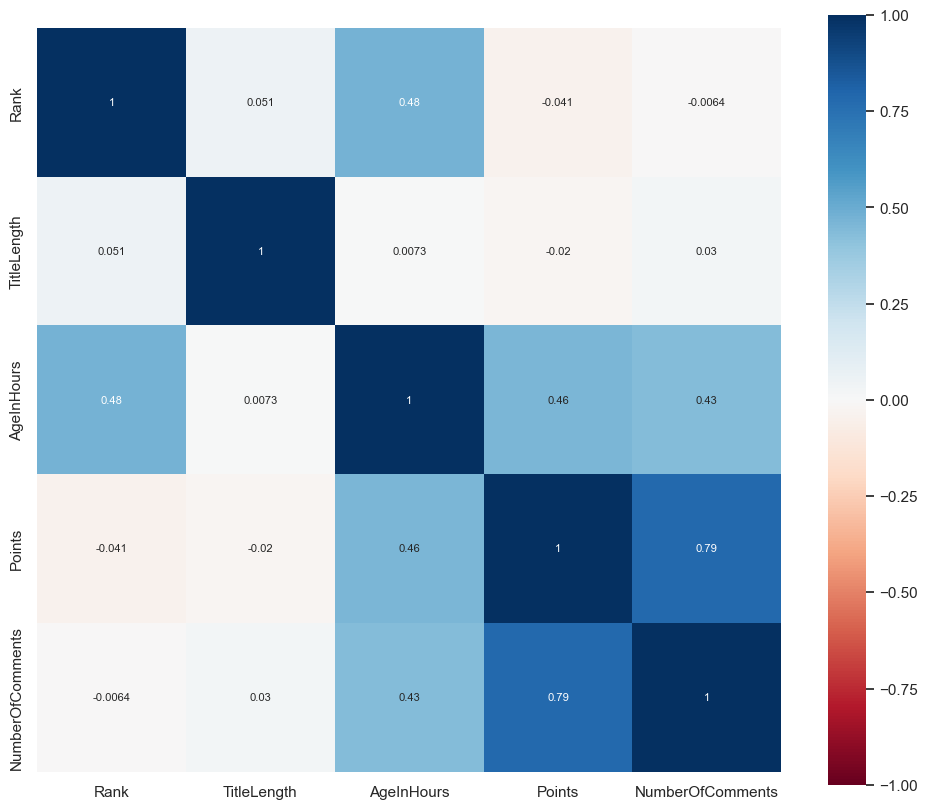

In [275]:
myDFsubSet = myDF[['Rank', 'TitleLength', 'AgeInHours', 'Points', 'NumberOfComments']]
sns.set(rc = {'figure.figsize':(12, 10)})
heatmap = sns.heatmap(myDFsubSet.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, annot_kws={'fontsize':8, 'fontweight':'normal'},square=True)

From the above heatmap, it appears that there is a slight lineral correlation between Points and AgeInHours, Points and NumberOfComments, NumberOfComments and AgeInHours, and Rank and AgeInHours.

# Part 3 - Classification

In [276]:
#transform the rank variable into an indicator variable (1 for front page, 0 for not)
def frontToNum(x):
    if x <= 30:
        return 1
    else: 
        return 0

myDF[ "Rank" ] = myDF[ "Rank" ].apply( frontToNum )
myDF

,Rank,TitleLength,AgeInHours,Points,NumberOfComments,AgeAndPoints,AgeAndComments,AgeAndTitle
0,1,37,0.55,80,36,47.590319,49.082389,48.294634
1,1,38,5.00,475,208,37.213683,45.531551,59.696202
2,1,65,5.00,454,198,38.553802,46.553627,62.438906
3,1,49,4.00,244,101,48.622326,53.315209,58.274277
4,1,85,1.00,42,29,51.514996,51.216492,54.313248
...,...,...,...,...,...,...,...,...
145,0,48,6.00,48,51,67.795435,64.730699,63.251341
146,0,89,24.00,201,119,118.019702,114.526569,113.123998
147,0,34,6.00,8,4,70.348043,69.534456,61.829198
148,0,71,21.00,76,25,115.998603,114.676419,103.677560


In [277]:
model = smf.logit( formula="Rank ~ AgeAndPoints", data=myDF ).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.431593
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Rank   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Jun 2023   Pseudo R-squ.:                  0.1375
Time:                        19:07:10   Log-Likelihood:                -64.739
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                 5.534e-06
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1841      0.956      2.285      0.022       0.311       4.057
AgeAndPoints    -0.0525      0.015     -3.543      0.000      -0.082      -0.023
================================================================================
"""

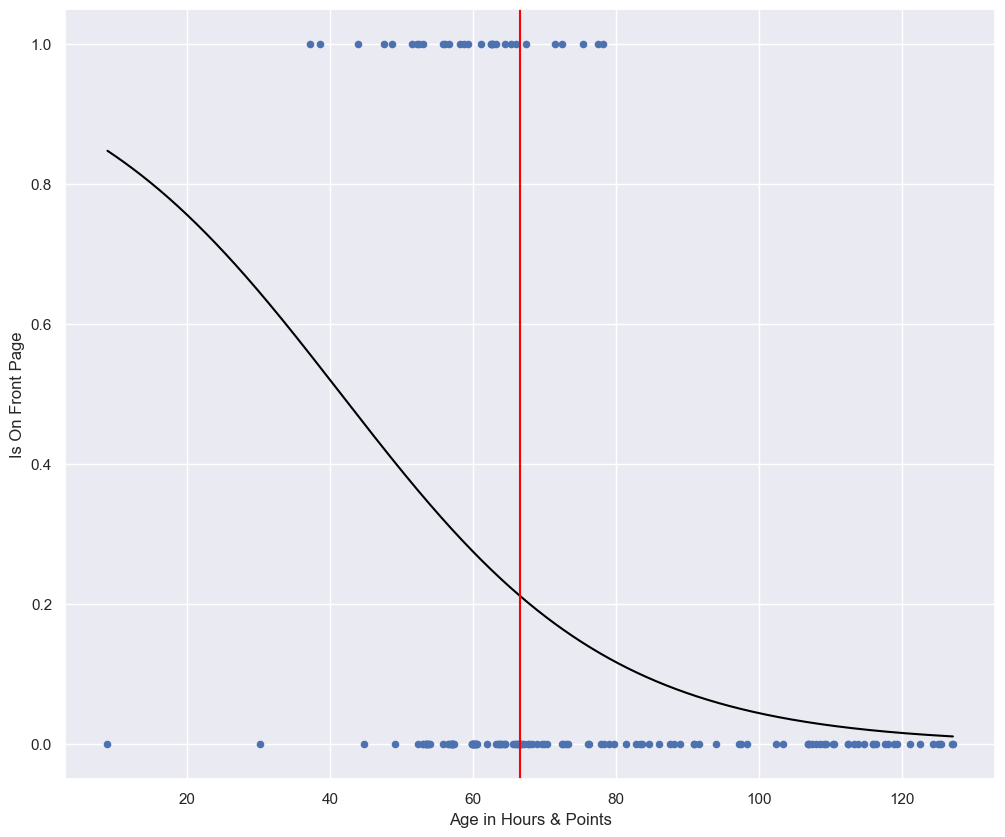

In [293]:
logistic = lambda x: 1 / ( 1 + np.exp(-x) )
myDF.plot.scatter( x='AgeAndPoints', y='Rank')


xs = np.linspace( myDF['AgeAndPoints'].min(), myDF['AgeAndPoints'].max(), 1000 )

par = dict( model.params )
par
_ = plt.plot( xs, logistic( par['Intercept'] + par['AgeAndPoints']*xs) , color='Black' )

_ = plt.xlabel( 'Age in Hours & Points' )
_ = plt.ylabel( 'Is On Front Page' )

plt.axvline(x = myDF['AgeAndPoints'].median(), color = 'red', label = 'axvline - full height')
# plt.show()



In [294]:
model2 = smf.logit( formula="Rank ~ AgeInHours", data=myDF ).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.466770
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Rank   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Wed, 14 Jun 2023   Pseudo R-squ.:                 0.06721
Time:                        10:45:05   Log-Likelihood:                -70.015
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                  0.001491
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5835      0.316     -1.847      0.065      -1.203       0.036
AgeInHours    -0.0961      0.035     -2.769      0.006      -0.164      -0.028
==============================================================================
"""

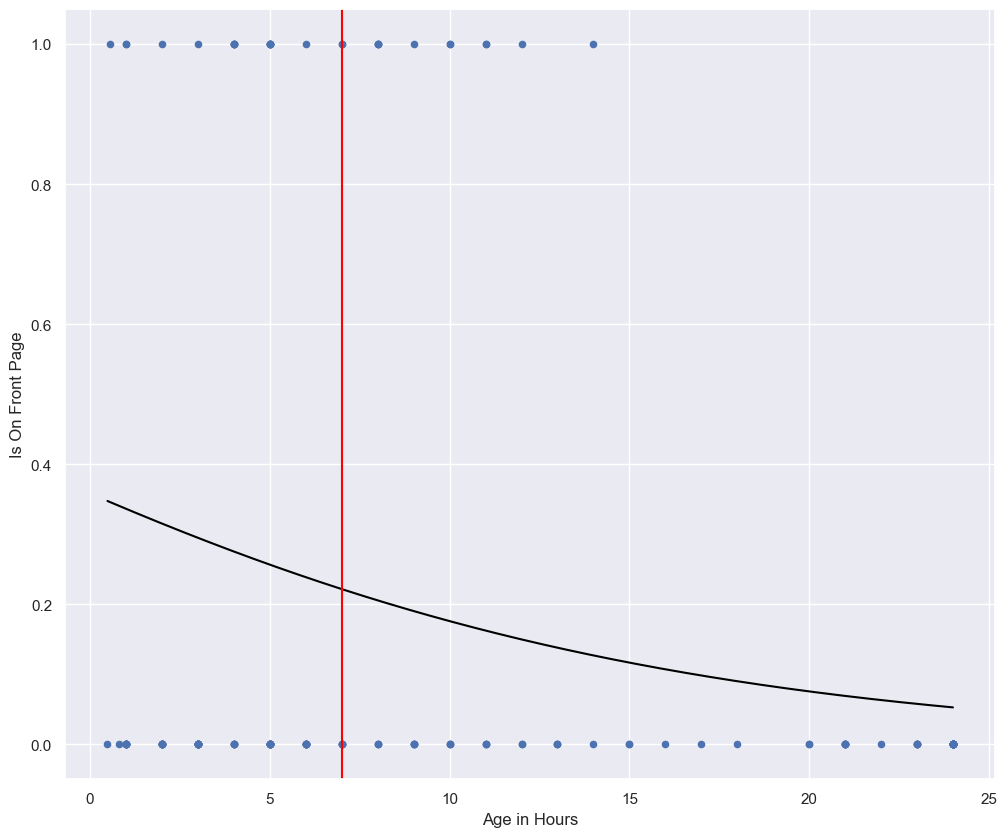

In [296]:
myDF.plot.scatter( x='AgeInHours', y='Rank')


xs = np.linspace( myDF['AgeInHours'].min(), myDF['AgeInHours'].max(), 1000 )

par = dict( model2.params )
par
_ = plt.plot( xs, logistic( par['Intercept'] + par['AgeInHours']*xs) , color='Black' )

_ = plt.xlabel( 'Age in Hours' )
_ = plt.ylabel( 'Is On Front Page' )

plt.axvline(x = myDF['AgeInHours'].median(), color = 'red', label = 'axvline - full height')

### What do your regressions tell you about making the front page?
The regressions tell us that posts that are newer or ones that have greater traffic (points, comments) are more likely to make the front page